# CI-0115 Probabilidad y Estadística
## Prof. Sebastián Ruiz Blais
### I - 2024

### Proyecto: tercera entrega

#### Daniel Rojas Morales - C26836
#### José Pablo Mora Cubillo - B75044

---

# Bibliotecas utilizadas

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import sqrt

# Bibliotecas utilizadas en las pruebas estadísticas 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import kstest
import statsmodels.api as sm

# Regresión
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Keras y tensorflow para redes neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam

# Explicación de las columnas en las bases de datos de vinos:

1. **Fixed Acidity:** La cantidad total de ácidos (g/l) en el vino.
2. **Volatile Acidity:** La cantidad de ácidos volátiles (g/l) en el vino.
3. **Citric Acid:** La cantidad de ácido cítrico (g/l) en el vino.
4. **Residual Sugar:** La cantidad de azúcar residual (g/l) que queda después de la fermentación.
5. **Chlorides:** La cantidad de cloruros (g/l) en el vino.
6. **Free Sulfur Dioxide:** La cantidad de dióxido de azufre libre (mg/l) en el vino.
7. **Total Sulfur Dioxide:** La cantidad total de dióxido de azufre (mg/l) en el vino.
8. **Density:** La densidad del vino (g/cm³).
9. **pH:** El nivel de acidez o alcalinidad del vino, en una escala de 0 a 14.
10. **Sulphates:** La cantidad de sulfatos (g/l) en el vino.
11. **Alcohol:** El contenido de alcohol (% vol.) en el vino.
12. **Quality:** La calidad del vino, evaluada en una escala de 1 a 10.
13. **Wine Type:** El tipo de vino (blanco o rojo/tinto). 

# Cargar y manipular los datos utilizados

In [2]:
# cargar los datos
dataWhite = pd.read_csv('winequality-white.csv', sep=';')
dataRed = pd.read_csv('winequality-red.csv')

In [3]:
# Para los vinos rojos, agregamos una nueva columna llamada `data_type` y a todas las observaciones le asignamos como valor `Red`
dataRed['wine_type'] = "Red"

# Para los vinos blanco, agregamos una nueva columna llamada `data_type` y a todas las observaciones le asignamos como valor `White`
dataWhite['wine_type'] = "White"

# Se realiza la concatenación
dataWine = pd.concat([dataRed, dataWhite], axis = 0) # `axis=0` indica que se debe concatenar verticalmente
dataWine.reset_index(drop=True, inplace=True) # resetear los índices

In [4]:
# Renombrar variables de interes para la base de datos de vinos
dataWine = dataWine.rename(columns={'fixed acidity' : 'fixed_acidity',
                                    'citric acid' : 'citric_acid',
                                    'residual sugar' : 'residual_sugar',
                                    'free sulfur dioxide' : 'free_SO2',
                                    'total sulfur dioxide' : 'total_SO2',
                                    'volatile acidity' : 'volatile_acidity'})

In [5]:
# Excluir outliers (considerados en entrega anterior los que estaban +/- 3 veces el IQR)

# Almacenamos el nombre de columnas en una lista, excluimos las últimas dos
columns = dataWine.iloc[:,:11].columns.tolist() # castear objeto de tipo ` pandas.core.indexes.base.Index` a una lista

nrows_before = dataWine.shape[0]
# Los datos se almacen en un diccionario separando por tipo de vinp
quantileDic = {
  "Red":[],
  "White":[]
}

for i in range(dataWine.shape[1] - 2):
    for name in quantileDic:
        # Calcular primer cuartil, tercer cuartil y IQR
        Q1 = dataWine[dataWine["wine_type"] == name][columns[i]].quantile(0.25)
        Q3 = dataWine[dataWine["wine_type"] == name][columns[i]].quantile(0.75)
        quantileDic[name].append([Q1, Q3, Q3 - Q1])
        


for i in range(dataWine.shape[1] - 2): # excluir ultimas dos columnas
    for name in quantileDic:
        dataWine.reset_index(drop=True, inplace=True) # resetear los índices, de lo contrarío se presenta un error
        lower = quantileDic[name][i][0] - 3*quantileDic[name][i][2] # Q1 - 3*IQR
        upper = quantileDic[name][i][1] + 3*quantileDic[name][i][2] # Q3 - 3*IQR
        # Crear un array que contenga las filas donde se superó el límite superior o inferior 
        upper_list = np.where((dataWine[columns[i]] >= upper) & (dataWine["wine_type"] == name))[0]
        lower_list = np.where((dataWine[columns[i]] <= lower) & (dataWine["wine_type"] == name))[0]
        
        
        # Eliminar los outliers
        dataWine.drop(index=upper_list, inplace=True)
        dataWine.drop(index=lower_list, inplace=True)

In [6]:
# Visualizar el resultado de las manipulaciones realizadas:
dataWine

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
6118,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
6119,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
6120,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


Como se muestra a continuación, las calidades 3 y 9 presentan pocos datos. Por lo que se va a crear un nuevo DataFrame sin estas categorias

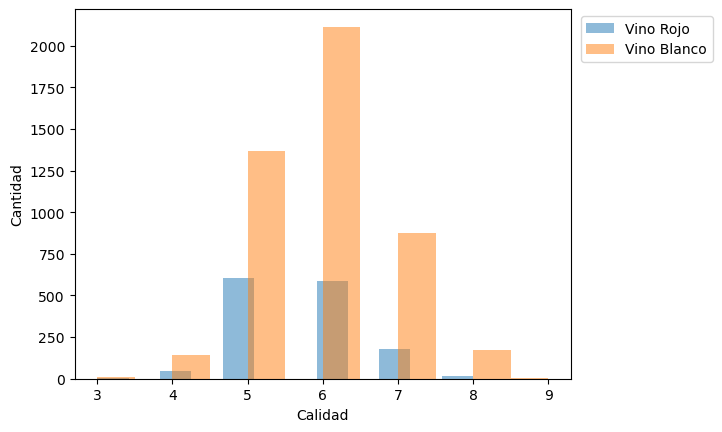

In [7]:
plt.hist(dataWine[(dataWine["wine_type"] == "Red")]["quality"], alpha = 0.5, bins = 12, label = "Vino Rojo")
plt.hist(dataWine[(dataWine["wine_type"] == "White")]["quality"], alpha = 0.5, bins = 12, label = "Vino Blanco")
plt.legend(bbox_to_anchor = (1.3, 1)) # `bbox_to_anchor` para mover la leyenda fuera del gráfico
plt.xlabel("Calidad")
plt.ylabel("Cantidad")
plt.show()

In [8]:
# Eliminar calidades 3 y 9
dataWineQuality4_8 = dataWine[~dataWine["quality"].isin([3, 9])]
dataWineQuality4_8

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality,wine_type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,Red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,Red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,Red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,Red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6117,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,White
6118,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,White
6119,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,White
6120,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,White


# (1)

# Kolmogorov-Smirnov

Utilizamos la prueba de **Kolmogorov-Smirnov** porque es la recomendada cuando se trabaja con más de 50 datos.

- **Hipótesis nula - H0:** la distribución de la variable se ajusta a la distribución normal.
    - Se rechaza cuando p < 0.05. 
- **Hipótesis alternativa - H1:** la distribución de la variable no se ajusta a la distribución normal. 

Primero creamos una función que determina si la variable se ajusta a una distribución normal, en caso de que no se ajuste, realiza diferentes transformaciónes (logarítmica, raíz cúbica y raíz cuadrada) y comprueba si el resultado es normal.

In [9]:
def determine_normality(dataFrame, variable, category):
    """
    Determina si una variable dada se ajusta a una distribución normal, en caso contrario realiza diferentes 
    transformaciones para determinar si generan una variable normal. 
    
    La función realiza la prueba de Kolmogorov-Smirnov (K-S) para verificar si la distribución de la variable 
    es normal dentro de cada categoría. Si no es normal, aplica las transformaciones logarítmicas, de raíz cúbicas
    y de raíz cuadrada. Posteriormente la se vuelve a realizar la prueba K-S para cada transformación.

    Parámetros:
    -----------
    dataFrame : pandas.DataFrame
        El DataFrame que contiene los datos.
    variable : str
        El nombre de la columna que contiene la variable a analizar.
    category : str
        El nombre de la columna que contiene las categorías de los datos.
    """
    
    print("===========================================================================================")
    # obtener las diferentes categorias de los datos para aplicar la prueba de Kolmogorov-Smirnov
    category_list = dataFrame[category].unique()
    for current_category in category_list:
        # Obtenemos los datos para la categoria actual
        current_data = dataFrame[dataFrame[category] == current_category][variable]
        # primero generamos un qqplot
        # Nota: si es normal, los puntos azules se deben ajustar con la línea roja
        fig = sm.qqplot(current_data, line='45') #<- Solo se genera para la variable sin transformar 
        fig.set_size_inches(2,2)
        plt.title('Q-Q Plot')
        plt.xlabel('Theoretical Quantiles')
        plt.ylabel('Sample Quantiles')
        plt.show()
        # realizar prueba de Kolmogorov-Smirnov de acuerdo a la categoria
        result = kstest(current_data, 'norm', args = (np.mean(current_data), np.std(current_data, ddof=1))) # comparar contra una distribución normal
        print(f"Categoria = {current_category} | Variable  = {variable}")
        if result.pvalue < 0.05:
            print(f"\t- Valor_p = {result.pvalue} < 0.05, por lo tanto la variable no presenta distribución normal.")
            print("\nTransformaciones:")
            
            #  Transformación logaritmica (usando logaritmo natural)
            current_data = np.log(dataFrame[dataFrame[category] == current_category][variable])
            
            result_log = kstest(current_data, 'norm', args = (np.mean(current_data), np.std(current_data, ddof=1)))
            
            if result_log.pvalue < 0.5:
                print(f"\t- Transformación logarítmica: valor p = {result_log.pvalue} < 0.05, por lo tanto la variable no presenta distribución normal.")
            else:
                print(f"\t- Transformación logarítmica: valor p = {result_log.pvalue} > 0.05, por lo tanto la variable presenta distribución normal.")
                
            # Transformación de raíz cúbica
            current_data = np.cbrt(dataFrame[dataFrame[category] == current_category][variable])
            result_cube = kstest(current_data, 'norm', args = (np.mean(current_data), np.std(current_data, ddof=1)))
            if result_cube.pvalue < 0.05:
                print(f"\t- Transformación con raíz cúbica: valor p = {result_cube.pvalue} < 0.05, por lo tanto la variable no presenta distribución normal.")
            else:
                print(f"\t- Transformación con raíz cúbica: valor p = {result_cube.pvalue} > 0.05, por lo tanto la variable presenta distribución normal.")
            
            # Transformación con raíz cuadrada
            current_data = np.sqrt(dataFrame[dataFrame[category] == current_category][variable])
            result_sqrt = kstest(current_data, 'norm', args = (np.mean(current_data), np.std(current_data, ddof=1)))
            if result_sqrt.pvalue < 0.05:
                print(f"\t- Transformación con raíz cuadrada: valor p = {result_sqrt.pvalue} < 0.05, por lo tanto la variable no presenta distribución normal.")
            else:
                print(f"\t- Transformación con raíz cuadrada: valor p = {result_sqrt.pvalue} > 0.05, por lo tanto la variable presenta distribución normal.")
        else:
            print(f"\tvalor_p = {result.pvalue} > 0.05, por lo tanto la variable `{variable}` presenta distribución normal.")
        print("===========================================================================================")

Vamos a determinar si las conclusiones generadas en las secciones 9-11 de la segunda entrega a partir de `ANOVAS` son válidas, para esto vamos a usar la función anterior. 

Como se muestra en el segmento siguiente, ninguna de las variables usadas en el proyecto anterior cumple el supuesto de normalidad, por lo que no se puede afirmar que las conclusiones de las secciones 9-11 sean correctas. Además, se puede observar que en ningún caso se pudo generar una muestra normal a partir de transformaciones. 

 1) **¿Existen diferencias significativas entre las medias de los valores de `alcohol` para las diferentes calidades?**

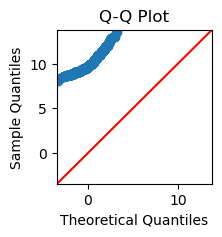

Categoria = 5 | Variable  = alcohol
	- Valor_p = 6.525986774527576e-33 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 4.2645975091246504e-30 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 4.3073550156577186e-31 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 1.4351444011836062e-31 < 0.05, por lo tanto la variable no presenta distribución normal.


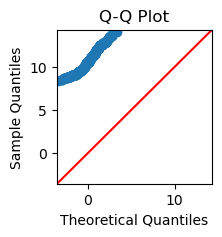

Categoria = 6 | Variable  = alcohol
	- Valor_p = 3.433744302075681e-11 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 1.0385824424761436e-08 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 3.898177767189161e-09 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 1.179971803159317e-09 < 0.05, por lo tanto la variable no presenta distribución normal.


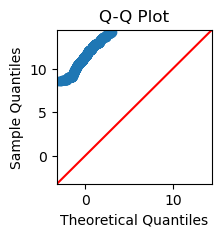

Categoria = 7 | Variable  = alcohol
	- Valor_p = 0.0023078172131654542 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 0.000216504304635072 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 0.0004618967207773766 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 0.0006840081347697369 < 0.05, por lo tanto la variable no presenta distribución normal.


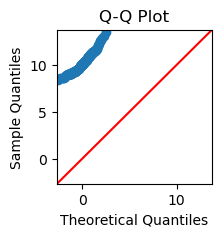

Categoria = 4 | Variable  = alcohol
	valor_p = 0.18186488520474198 > 0.05, por lo tanto la variable `alcohol` presenta distribución normal.


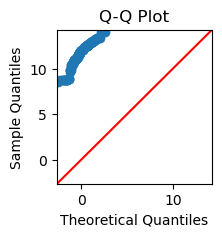

Categoria = 8 | Variable  = alcohol
	- Valor_p = 0.016084700876212527 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 0.00295642132693743 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 0.005789467397924048 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 0.007493265073515828 < 0.05, por lo tanto la variable no presenta distribución normal.


In [10]:
determine_normality(dataWineQuality4_8, "alcohol", "quality")

2) **¿Existen diferencias significativas entre las medias de los valores de `density` para las diferentes calidades?**  

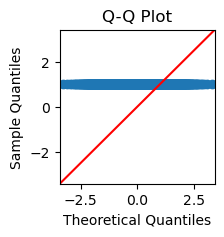

Categoria = 5 | Variable  = density
	- Valor_p = 3.496931162363526e-05 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 2.853032391607292e-05 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 3.053960580742721e-05 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 3.159406910847018e-05 < 0.05, por lo tanto la variable no presenta distribución normal.


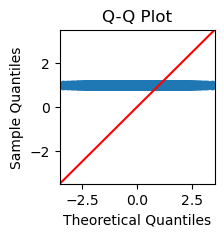

Categoria = 6 | Variable  = density
	- Valor_p = 2.4626501783564963e-06 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 2.9087209744768222e-06 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 2.7517435336622253e-06 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 2.676447439860382e-06 < 0.05, por lo tanto la variable no presenta distribución normal.


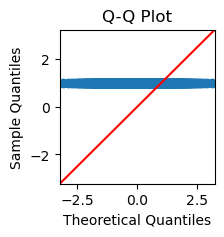

Categoria = 7 | Variable  = density
	- Valor_p = 6.263452021456226e-11 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 7.763759235843695e-11 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 7.227844258280287e-11 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 6.973785087101411e-11 < 0.05, por lo tanto la variable no presenta distribución normal.


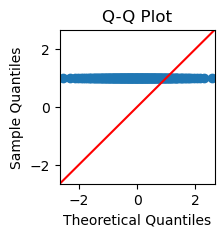

Categoria = 4 | Variable  = density
	valor_p = 0.7068732892810603 > 0.05, por lo tanto la variable `density` presenta distribución normal.


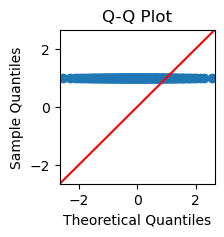

Categoria = 8 | Variable  = density
	- Valor_p = 0.01777225580556326 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 0.01867787604691575 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 0.018371476237146904 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 0.018219984587392386 < 0.05, por lo tanto la variable no presenta distribución normal.


In [11]:
determine_normality(dataWineQuality4_8, "density", "quality")

 3) **¿Existen diferencias significativas entre las medias de los valores de `volatile_acidity` para los tipos de vino?**

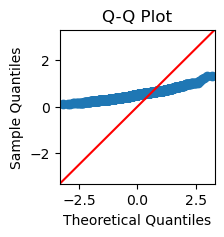

Categoria = Red | Variable  = volatile_acidity
	- Valor_p = 0.00042090355249287744 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 1.0329805584813187e-06 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 0.00044017726735655593 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 0.006359515923822508 < 0.05, por lo tanto la variable no presenta distribución normal.


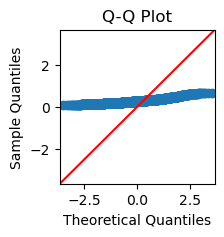

Categoria = White | Variable  = volatile_acidity
	- Valor_p = 5.175748406183013e-34 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 6.973052643843505e-07 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 1.5341807389305632e-09 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 4.0388007943281145e-14 < 0.05, por lo tanto la variable no presenta distribución normal.


In [12]:
determine_normality(dataWineQuality4_8, "volatile_acidity", "wine_type")

 4) **¿Existen diferencias significativas entre las medias de los valores de `chlorides` para los tipos de vino?**

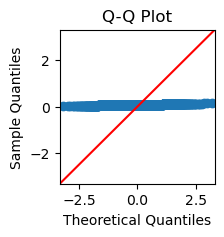

Categoria = Red | Variable  = chlorides
	- Valor_p = 2.449145455645407e-07 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 7.842731945895476e-09 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 7.173513414712996e-06 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 9.787128790724699e-05 < 0.05, por lo tanto la variable no presenta distribución normal.


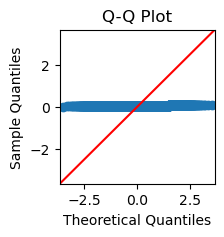

Categoria = White | Variable  = chlorides
	- Valor_p = 1.8439162979750254e-07 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 6.724533521191725e-14 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 8.956238331077941e-08 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 2.8203358009682027e-05 < 0.05, por lo tanto la variable no presenta distribución normal.


In [13]:
determine_normality(dataWineQuality4_8, "chlorides", "wine_type")

 5) **¿Existen diferencias significativas entre las medias de los valores de `total_SO2` para los tipos de vino?**

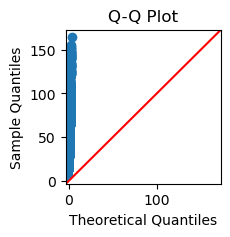

Categoria = Red | Variable  = total_SO2
	- Valor_p = 1.578026612417874e-18 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 0.13039636383880804 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 8.536400654233879e-05 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 6.990121418544201e-07 < 0.05, por lo tanto la variable no presenta distribución normal.


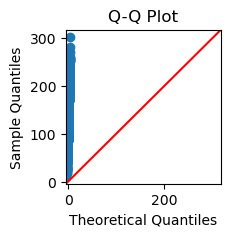

Categoria = White | Variable  = total_SO2
	- Valor_p = 1.0775781666617306e-08 < 0.05, por lo tanto la variable no presenta distribución normal.

Transformaciones:
	- Transformación logarítmica: valor p = 4.6371865636793855e-06 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cúbica: valor p = 0.007823541439003337 < 0.05, por lo tanto la variable no presenta distribución normal.
	- Transformación con raíz cuadrada: valor p = 0.05105746153091306 > 0.05, por lo tanto la variable presenta distribución normal.


In [14]:
determine_normality(dataWineQuality4_8, "total_SO2", "wine_type")

# (2)

# Regresiones no lineales

Para calcular la regresión se utilizarán los modelos de 'Random Forest'.

Random Forest es una técnica de aprendizaje automático que se utiliza tanto para problemas de regresión como de clasificación. Aunque es más conocida en contextos de clasificación, también se puede adaptar para tareas de regresión.

En el contexto de regresión se utiliza de la siguiente manera:

****1. Ensamble de Árboles de Decisión:**** 
Random Forest se basa en un ensamble de árboles de decisión. Cada árbol de decisión se construye de manera independiente utilizando diferentes subconjuntos del conjunto de datos de entrenamiento y diferentes subconjuntos de características.

****2. Bootstrap Aggregating (Bagging):**** 
Para construir cada árbol de decisión, se emplea un método llamado bagging. Esto implica tomar muestras aleatorias con reemplazo del conjunto de entrenamiento original. Cada árbol se entrena con una de estas muestras.

****3. Selección Aleatoria de Características:****
Además del muestreo aleatorio de datos, cada árbol de decisión se construye utilizando solo un subconjunto aleatorio de las características disponibles en cada división del árbol. Esta selección aleatoria de características ayuda a decorrelacionar los árboles en el ensamble.

****4. Predicción:**** 
Una vez que se han entrenado todos los árboles, para hacer una predicción en el caso de regresión, se toma el promedio de las predicciones individuales de cada árbol. Esto proporciona una predicción final más estable y generalmente más precisa que la predicción de un solo árbol de decisión.

En resumen, Random Forest para regresión combina múltiples árboles de decisión entrenados en diferentes subconjuntos de datos y características para producir una predicción final promediada, que tiende a ser más precisa y generalizable que la predicción de un solo árbol de decisión.

---

En los resultados se esperan las siguientes variables:

****MSE (Error Cuadrático Medio):**** Es una medida de la calidad de una estimación numérica. Cuanto menor sea el MSE, mejor será el modelo en términos de precisión. El MSE se calcula como la media de los cuadrados de los errores, donde el error es la diferencia entre el valor predicho y el valor real.

****R^2 (Coeficiente de Determinación):**** Es una medida estadística que indica qué tan bien se ajustan los valores predichos por el modelo a los valores observados. Puede interpretarse como la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Un valor de R^2 más cercano a 1 indica un mejor ajuste del modelo a los datos.

## Regresión  `alcohol` según `quality`

Primero se graficarán la variables `alcohol` según la calidad. 

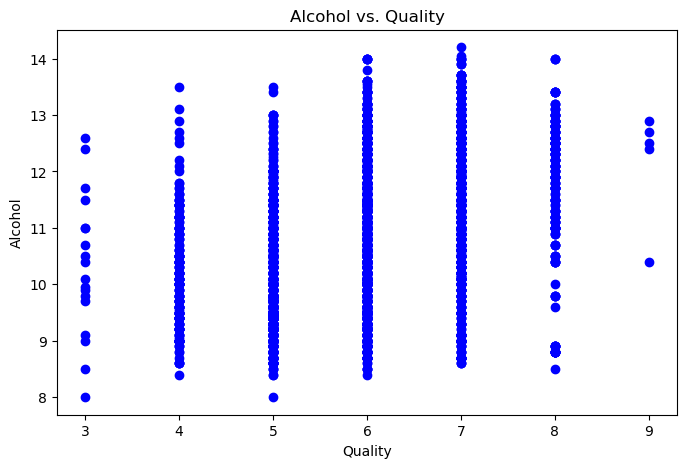

In [42]:
# Graficar Alcohol vs. Quality
plt.figure(figsize=(8, 5))
x_alcohol, y_quality = dataWine["quality"].values, dataWine["alcohol"].values
plt.plot(x_alcohol, y_quality, 'bo')
plt.ylabel('Alcohol')
plt.xlabel('Quality')
plt.title('Alcohol vs. Quality')
plt.show()

Ajuste inicial:

Random Forest:
MSE: 1.0860653535938665
R^2: 0.22351373088042725


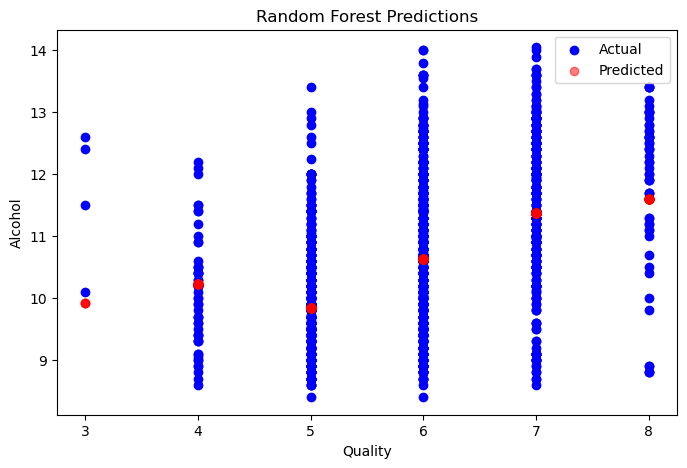

In [46]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = dataWine[['quality']]
y = dataWine['alcohol']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

# Evaluación de modelo
print("Random Forest:")
print(f"MSE: {mean_squared_error(y_test, y_rf_pred)}")
print(f"R^2: {r2_score(y_test, y_rf_pred)}")

# Graficar predicciones de Random Forest
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_rf_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('Alcohol')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()

Ahora se ejecuta el mismo modelo pero con ajustes de optimización:

Random Forest (Optimized):
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
MSE: 1.08606616105687
R^2: 0.2235131535818945


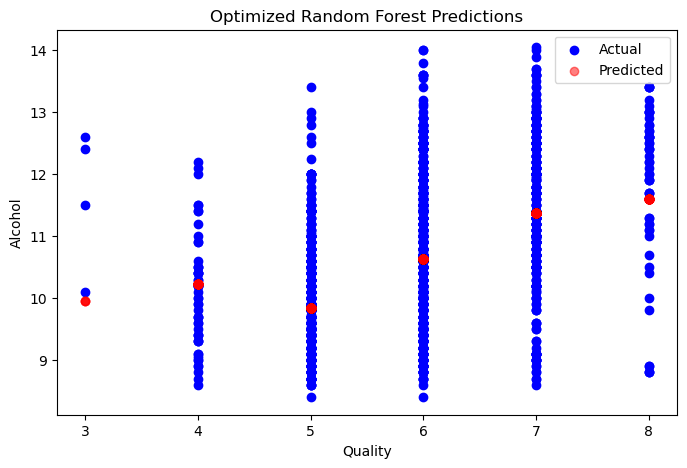

In [47]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = dataWine[['quality']]
y = dataWine['alcohol']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest - Grid Search
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

# Evaluación de modelos optimizados
print("Random Forest (Optimized):")
print(f"Best Params: {rf_model.best_params_}")
print(f"MSE: {mean_squared_error(y_test, y_rf_pred)}")
print(f"R^2: {r2_score(y_test, y_rf_pred)}")

# Graficar predicciones optimizadas de Random Forest
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_rf_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('Alcohol')
plt.title('Optimized Random Forest Predictions')
plt.legend()
plt.show()

### Análisis de los resultados

****Random Forest:**** Tanto en el ajuste inicial como en el optimizado, muestra un MSE y un R^2 similares, lo que indica que el ajuste no se modificó significativamente con la optimización de los parámetros. El modelo tiene un MSE de alrededor de 1.086 y un R^2 de aproximadamente 0.223, lo que sugiere que explica aproximadamente el 22.3% de la variabilidad en los datos.

## Regresión  `pH` según `quality`

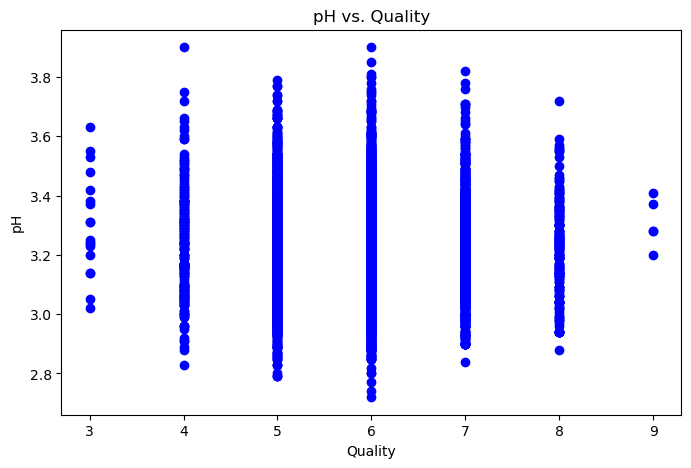

In [48]:
# Graficar pH vs. Quality
plt.figure(figsize=(8, 5))
x_alcohol, y_quality = dataWine["quality"].values, dataWine["pH"].values
plt.plot(x_alcohol, y_quality, 'bo')
plt.ylabel('pH')
plt.xlabel('Quality')
plt.title('pH vs. Quality')
plt.show()

Ajuste inicial:

Random Forest:
MSE: 0.025739783040006278
R^2: -0.002604358467293455


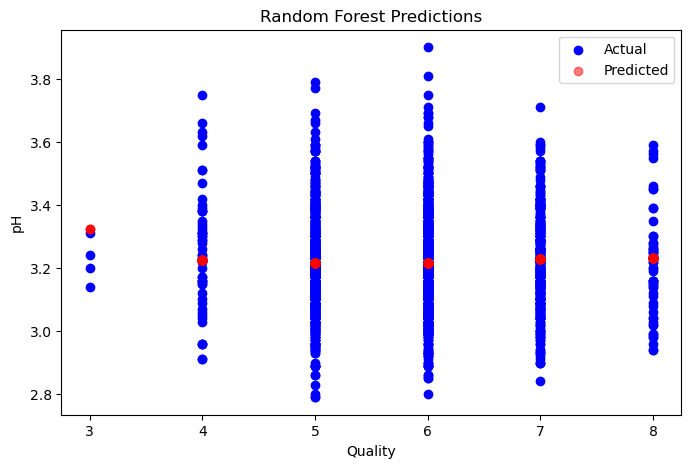

In [50]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = dataWine[['quality']]
y = dataWine['pH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

# Evaluación de modelos
print("Random Forest:")
print(f"MSE: {mean_squared_error(y_test, y_rf_pred)}")
print(f"R^2: {r2_score(y_test, y_rf_pred)}")

# Graficar predicciones de Random Forest
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_rf_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('pH')
plt.title('Random Forest Predictions')
plt.legend()
plt.show()

Ahora se ejecuta el mismo modelo pero con ajustes de optimización:

Random Forest (Optimized):
Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
MSE: 0.02574080761274195
R^2: -0.002644267159948477


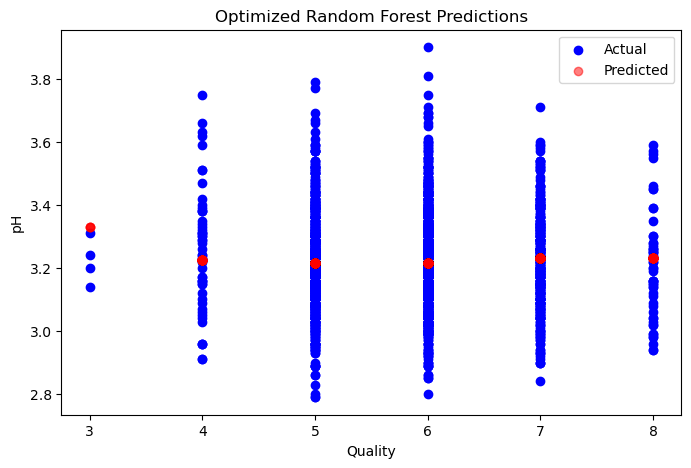

In [51]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = dataWine[['quality']]
y = dataWine['pH']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest - Grid Search
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_model.fit(X_train, y_train)
y_rf_pred = rf_model.predict(X_test)

# Evaluación de modelos optimizados
print("Random Forest (Optimized):")
print(f"Best Params: {rf_model.best_params_}")
print(f"MSE: {mean_squared_error(y_test, y_rf_pred)}")
print(f"R^2: {r2_score(y_test, y_rf_pred)}")

# Graficar predicciones optimizadas de Random Forest
plt.figure(figsize=(8, 5))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_rf_pred, color='red', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('pH')
plt.title('Optimized Random Forest Predictions')
plt.legend()
plt.show()

### Análisis de los resultados

****Random Forest:**** 
En este caso, la optimización de los parámetros del modelo Random Forest no resultó en una mejora significativa. Tanto el MSE como el R^2 se mantuvieron casi idénticos, indicando que el ajuste de parámetros (max_depth, min_samples_split, y n_estimators) no tuvo un impacto sustancial en el rendimiento del modelo.

Además, el hecho de que el R^2 sea negativo en ambos casos sugiere que el modelo Random Forest está teniendo problemas para capturar la estructura de los datos. En un escenario ideal, el R^2 debería ser positivo y cercano a 1 para un buen ajuste. El MSE bajo muestra que los errores de predicción son pequeños, pero el R^2 negativo sugiere que estas predicciones no están bien alineadas con la variabilidad de los datos.

Por lo que se utilizará el modelo Support Vector Regression (SVR) para obtener un punto de vista distinto de los datos

SVR (Initial):
MSE: 0.02589338395318719
R^2: -0.008587351594328885

SVR (Optimized):
Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
MSE: 0.025781163647868283
R^2: -0.004216197142622891


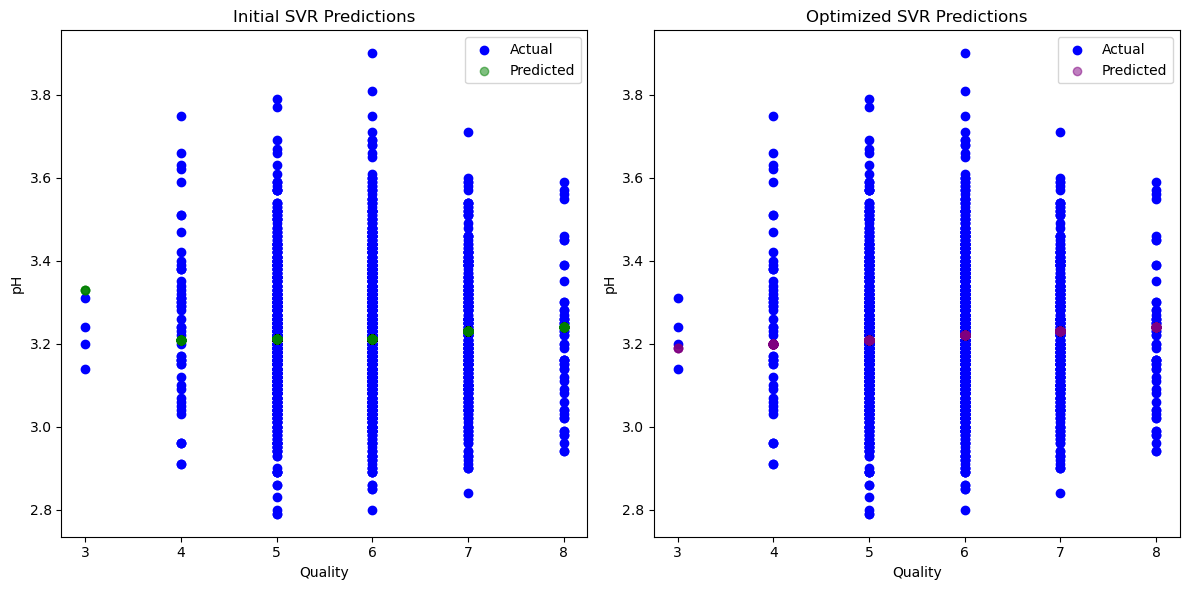

In [13]:
# Definir características y variable objetivo
X = dataWine[['quality']]
y = dataWine['pH']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarizar las características (esto es importante para SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo Inicial: SVR con parámetros por defecto
initial_model = SVR()
initial_model.fit(X_train_scaled, y_train)
y_initial_pred = initial_model.predict(X_test_scaled)

# Evaluar el modelo inicial
initial_mse = mean_squared_error(y_test, y_initial_pred)
initial_r2 = r2_score(y_test, y_initial_pred)

print("SVR (Initial):")
print(f"MSE: {initial_mse}")
print(f"R^2: {initial_r2}")

# Optimización: SVR con búsqueda en cuadrícula
svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

# Crear el modelo SVR con búsqueda en cuadrícula
svr_model = GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_mean_squared_error')

# Ajustar el modelo y predecir
svr_model.fit(X_train_scaled, y_train)
y_svr_pred = svr_model.predict(X_test_scaled)

# Evaluar el modelo optimizado
optimized_mse = mean_squared_error(y_test, y_svr_pred)
optimized_r2 = r2_score(y_test, y_svr_pred)

print("\nSVR (Optimized):")
print(f"Best Params: {svr_model.best_params_}")
print(f"MSE: {optimized_mse}")
print(f"R^2: {optimized_r2}")

# Graficar predicciones
plt.figure(figsize=(12, 6))

# Gráfico para el modelo inicial
plt.subplot(1, 2, 1)
plt.scatter(X_test['quality'], y_test, color='blue', label='Actual')
plt.scatter(X_test['quality'], y_initial_pred, color='green', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('pH')
plt.title('Initial SVR Predictions')
plt.legend()

# Gráfico para el modelo optimizado
plt.subplot(1, 2, 2)
plt.scatter(X_test['quality'], y_test, color='blue', label='Actual')
plt.scatter(X_test['quality'], y_svr_pred, color='purple', alpha=0.5, label='Predicted')
plt.xlabel('Quality')
plt.ylabel('pH')
plt.title('Optimized SVR Predictions')
plt.legend()

plt.tight_layout()
plt.show()

### Análisis de resultados

SVR: MSE del modelo optimizado es ligeramente menor que el del modelo inicial, lo que indica una mejora leve en la precisión del modelo después de la optimización de los hiperparámetros. El R^2 del modelo optimizado es menos negativo que el del modelo inicial, lo que sugiere una mejora en la capacidad de predicción del modelo optimizado. Sin embargo, ambos valores son negativos, lo que significa que incluso el modelo optimizado no logra capturar adecuadamente la varianza en los datos.

Aunque en este caso el R^2 continúa siendo negativo se puede apreciar una tendencia apartir del modelo lo cual es óptimo para los resultados deseados.

# (3)

# Redes neuronales para predecir la calidad del vino 

Para está sección, el objetivo es predecir la calidad de un vino con base en sus propiedades fisicoquímicas. Sin embargo, como se muestra a continuación, el tamaño de las categorías se encuentra desbalanceadas.

In [15]:
dataWineQuality4_8.value_counts("quality")

quality
6    2698
5    1974
7    1050
4     190
8     187
dtype: int64

Vamos a agrupar las clases 4 y 5, así como las clases 7 y 8, posteriormente clasificamos las calidades en `low`, `medium` y `high`.

In [16]:
wine_quality_category = dataWineQuality4_8.copy()
wine_quality_category["quality_category"] = "medium"
# Asignar "high" a las filas con calidad 7 u 8
wine_quality_category.loc[wine_quality_category["quality"].isin([7, 8]), "quality_category"] = "high"
# Asignar "low" a las filas con calidad 4 o 5
wine_quality_category.loc[wine_quality_category["quality"].isin([4, 5]), "quality_category"] = "low"
wine_quality_category.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality,wine_type,quality_category
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red,low
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Red,low
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Red,low
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Red,medium
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Red,low


In [17]:
wine_quality_category.value_counts("quality_category")

quality_category
medium    2698
low       2164
high      1237
dtype: int64

Como los datos siguien desbalanceados, vamos a realizar un "undersampling" de las categorias "medium" y "low".

In [18]:
min_count = wine_quality_category['quality_category'].value_counts().min()
balanced_wine_data = wine_quality_category.groupby('quality_category').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
# comprobamos que los datos están balanceados
balanced_wine_data.value_counts("quality_category")

quality_category
high      1237
low       1237
medium    1237
dtype: int64

### Manipulación de las variables independientes

In [19]:
# Variables independientes (11 continuas + 1 categórica)
continuous_variables = balanced_wine_data[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
                                   'free_SO2', 'total_SO2', 'density', 'pH', 'sulphates', 'alcohol']].values
categorical_variable = balanced_wine_data[['wine_type']].values

In [20]:
# Trabajamos con arreglo de tipo `ndarray`
type(continuous_variables)

numpy.ndarray

In [21]:
# "One-hot encoding"
encoder = OneHotEncoder(sparse_output=False) # usamos `sparse_output = False` para evitar matrices donde la mayoría de los elementos son 0
categorical_variable_encoded = encoder.fit_transform(categorical_variable)
# Resultado codificado
categorical_variable_encoded

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]])

In [22]:
# Además, es necesario normalizar las variables continuas para evitar que la escala de estas afecte la clasificación. 
scaler = StandardScaler() # estandariza los valores para que tengan media 0 y desviación estándar 1
continuous_variables = scaler.fit_transform(continuous_variables)
continuous_variables

array([[-1.24058758,  0.55444075, -0.58330626, ...,  0.60235364,
        -0.20951409,  2.31509118],
       [-0.45085578,  3.22351877, -2.22954138, ...,  2.22017721,
         2.65166392,  1.3471285 ],
       [-1.9513462 ,  0.85100498, -1.03227947, ..., -0.08211017,
         2.21148269,  2.71840896],
       ...,
       [ 1.12860782, -0.63181614,  1.06292886, ..., -1.69993374,
        -0.28287763, -1.23410533],
       [ 0.0229833 ,  0.09311863, -0.88262174, ..., -0.3310061 ,
        -0.64969532, -0.66946043],
       [-0.92469486,  0.62034391, -0.95745061, ...,  1.03792153,
         1.844665  , -0.50813331]])

In [23]:
# Concatenamos horizontalmente las variables continuas normalizadas y la variable categorica codificada
independent_variables = np.hstack((continuous_variables, categorical_variable_encoded))
independent_variables[1] # primera fila

array([-0.45085578,  3.22351877, -2.22954138, -0.57620907,  1.09939429,
       -0.82315757, -1.4931161 ,  0.3671771 ,  2.22017721,  2.65166392,
        1.3471285 ,  1.        ,  0.        ])

### Manipulación de las variables dependientes

In [24]:
dependent_variable = balanced_wine_data[['quality_category']].values

In [25]:
# "One-hot encoding" para las etiquetas
dependent_variable_encoded =  encoder.fit_transform(dependent_variable)
dependent_variable_encoded # [high, low , medium]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

### Obtención de los datos de entranamiento y prueba

In [26]:
# Dividir los datos en entrenamiento y prueba
# Usar el 90% de los datos para entrenamiento y el 10% para prueba
# `stratify = y` se usa para mantener las mismas proporciones de clases en los conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(independent_variables, dependent_variable_encoded, test_size=0.1, random_state=42, stratify=dependent_variable)

In [27]:
y_test.shape

(372, 3)

### Crear la red neuronal 

Para la creación de la red neuronal, se probó entre diferentes: cantidades de capas, cantidades de neuronas por capa, función de activación (`relu`, `elu`,  `leaky_relu` y `tanh`), porcentaje de `Dropout`, valor de `epochs` y valor de `batch_size`. La configuración que se muestra a continuación es la que generó el mejor resultado de clasificación.

In [28]:
# Crear un modelo de tipo secuencial
model = Sequential()
# agregar la capa de entrada
model.add(Input(shape=(independent_variables.shape[1],)))  # Especificar la forma de entrada con Input
# Capas ocultas:
# Las capas densas son capas donde las neuronas se conectan con "todas las posibles" conexiones.  
# 'relu': función de activación no lineal,si la entrada es positiva,
# la salida es igual a la entrada; de lo contrario, la salida es cero.
# 64 neuronas con función de activación 'relu'
model.add(Dense(64, activation='relu'))
# `Dropout` ayuda a prevenir el sobreajuste al desactivar aleatoriamente neuronas durante el entrenamiento
model.add(Dropout(0.1))
# 64 neuronas con función de activación 'relu'
model.add(Dense(64, activation='relu'))
# agregar la capa de salida 
#  Función `softmax`: normaliza las salidas de las neuronas para que sumen 1 y se interpreten como probabilidades.
model.add(Dense(len(np.unique(dependent_variable)), activation='softmax'))  # Salida con n categorías

In [29]:
# Compilar el modelo con múltiples métricas
# Adam (Adaptive Moment Estimation): controla el tamaño de los pasos que el optimizador toma para actualizar los pesos del modelo.
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(name='precision')])

### Arquitectura del modelo:

En resumen, la arquitectura de la red neuronal cumple con que:

- El modelo es secuencial.
- Cuenta con una capa de entrada que especifica la forma de entrada.
- Dos capas ocultas con 64 neuronas cada una, activadas por la función ReLU.
- Se aplica un `dropout` con una tasa del 10 % para evitar el sobreajuste.
- La capa de salida tiene tantas neuronas como categorías (3 en total) y utiliza la función de activación `softmax`.

### Entrenamiento de la red neuronal

In [30]:
# Entrenar el modelo
record = model.fit(x_train, y_train, epochs=300, batch_size=32, validation_data=(x_test, y_test), verbose = False)

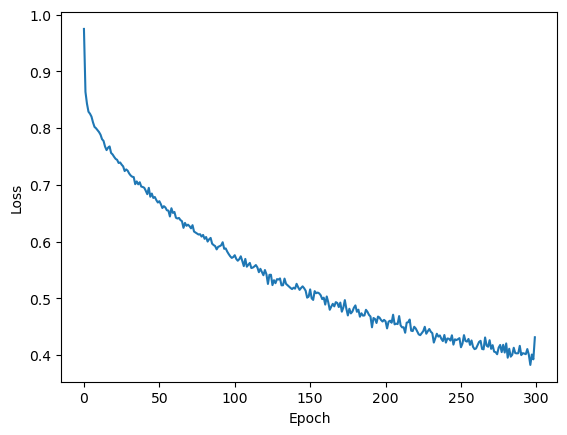

In [31]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(record.history["loss"])

### Evaluación de la red neuronal

In [32]:
# Evaluar el modelo 
loss, accuracy, precision = model.evaluate(x_test, y_test, verbose = False)

print(f'Accuracy: {accuracy}, Precision: {precision}, Loss {loss}')

Accuracy: 0.6747311949729919, Precision: 0.6816901564598083, Loss 0.8696956038475037


La métrica `accuracy` indica la proporción de predicciones correctas en relación con el total de predicciones. Mientras que `precision` mide la proporción de verdaderos positivos respecto a todas las predicciones positivas. **En ambos casos, las métricas se sitúan cerca de 0.65 (dependiendo de la corrida). Lo que nos indica que no podemos considerar que nuestro modelo sea un buen clasificador, sin embargo, presenta cierta capacidad predictiva.**

Como se muestra en la siguiente matriz de confusión, la categoría que mejor fue clasificada es `high`, seguido de `low`. En general, hay pocos donde un vino de calidad baja se calificó como uno de calidad alta, la mayoría de los errores se encuentran entre los vinos de calidad baja con media y alta con media.

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


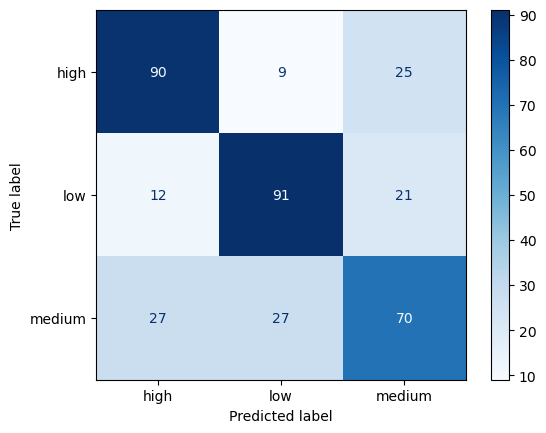

In [33]:
# Hacer predicciones en el conjunto de prueba
y_pred_prob = model.predict(x_test) # tiene la forma [high, low , medium]

# Convertir las probabilidades a clases
y_pred = np.argmax(y_pred_prob, axis=1) # 0 = high, 1 = low y 2 = medium

# Convertir y_test a clases si está en formato one-hot
y_true = np.argmax(y_test, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=("high", "low", "medium"))

disp.plot(cmap=plt.cm.Blues)

plt.show()

### Valores promedio de `accuracy` y `precision`

Para calcular los valores promedio, vamos a realizar 10 corridas, para esto 10 `seeds` (o) distintas en `train_test_split()`, lo que genera distintos conjuntos de prueba y entrenamiento. 

In [39]:
mean_accuracy = 0
mean_precision = 0
seeds = [30, 53, 65, 7, 12, 67, 44, 14, 5, 73]

In [40]:
for seed in seeds:
    # Separar los datos en prueba y entrenamiento
    x_train, x_test, y_train, y_test = train_test_split(independent_variables, dependent_variable_encoded, test_size=0.1, random_state = seed, stratify = dependent_variable)
    #Crear modelo y compilarlo
    model = Sequential()
    model.add(Input(shape=(independent_variables.shape[1],)))  # Especificar la forma de entrada con Input
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(len(np.unique(dependent_variable)), activation='softmax'))  # Salida con n categorías
    
    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', Precision(name='precision')])
    
    # Entrenar el modelo 
    record = model.fit(x_train, y_train, epochs=300, batch_size=32, validation_data=(x_test, y_test), verbose = False)
    
    # Evaluar el modelo e imprimir el resultado
    loss, accuracy, precision = model.evaluate(x_test, y_test, verbose = False)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Loss {loss}')
    print("===========================================================================================\n")
    
    mean_accuracy = mean_accuracy + accuracy
    mean_precision = mean_precision + precision

mean_accuracy = mean_accuracy / len(seeds)
mean_precision = mean_precision / len(seeds)
print(f"Mean accuracy: {mean_accuracy}, mean precision {mean_precision}")

Accuracy: 0.6451612710952759, Precision: 0.6475409865379333, Loss 1.1036744117736816

Accuracy: 0.6370967626571655, Precision: 0.6438746452331543, Loss 1.1433640718460083

Accuracy: 0.6209677457809448, Precision: 0.6275071501731873, Loss 1.0708895921707153

Accuracy: 0.6747311949729919, Precision: 0.6853932738304138, Loss 0.9502382874488831

Accuracy: 0.647849440574646, Precision: 0.6554622054100037, Loss 0.9479692578315735

Accuracy: 0.6559139490127563, Precision: 0.6657381653785706, Loss 1.178158164024353

Accuracy: 0.6586021780967712, Precision: 0.6676136255264282, Loss 0.967379093170166

Accuracy: 0.6908602118492126, Precision: 0.7163323760032654, Loss 0.9002346992492676

Accuracy: 0.6801075339317322, Precision: 0.6882022619247437, Loss 0.9301155805587769

Accuracy: 0.6209677457809448, Precision: 0.6340782046318054, Loss 1.086892008781433

Mean accuracy: 0.6532258033752442, mean precision 0.6631742894649506


Los datos promedios son concordantes con lo discutido en la sección `Evaluación de la red neuronal`. Es importante notar que los valores presentan cierta variación que es el resultado los diferentes datos que conforman los conjuntos de datos de prueba y entrenamiento en cada iteración.